In [49]:
# Note: I have made modifications to the scripts on this repository to remove sensitive information and reduce annotations, ensuring they can be shared without risk of confidentiality issues.purpose of script is to calculated concentration of anlayte based on HTRF readout

# input is 384-well plates with 4pt dilution to account of dynamic range of assay

# point selected based on distance from EC50 of standard 
# and not identified as being in hook


%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#inputs
os.chdir(### input path (folder) ###)
experiment_id = '9015'
extension = 'csv'
all_filenames = [i for i in glob.glob(fusion_id+'*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f,skiprows=1, header=0, nrows=384) for f in all_filenames])

In [ ]:
# default tiration of standard from liquid handler method, values as ng/mL
titr = {'A12': 1500, 'B12':750,'C12':250,'D12': 85, 'E12' : 30, 'F12' : 10, 'G12': 3, 'H12': 1}

# dilution factors of samples per quad in 384-well, diluted to account for dynamic range of assay
DFs= {'q1': 1, 'q2':8,'q3':64,'q4':512}

# 384-to-96 coordinate conversion
def convert_to_96_well_format(well_coord_384):
    row_384 = ord(well_coord_384[0]) - ord('A') + 1
    col_384 = int(well_coord_384[1:])
    
    # calculate corresponding column in 96-well format
    if col_384 % 2 == 0:
        col_384 = col_384 - 1
    else:
        col_384 = col_384
    col_96 = (col_384 - 1) % 2 * 12 + (col_384 + 1) // 2
    
    # calculate corresponding row in 96-well format
    if row_384 % 2 == 0:
        row_96 = row_384 / 2
    else:
        row_96 = row_384 + 1 / 2
    
    row_96_letter = chr(int(row_96) + ord('A') - 1)    

    # combine for the final 96-well coordinate
    well_96 = row_96_letter + str(col_96).zfill(2)
    
    return well_96

#classification of quads based on 384 well
def get_quad(well_coord_384):
    row_384 = ord(well_coord_384[0]) - ord('A') + 1
    col_384 = int(well_coord_384[1:])
    
    # determine the quad based on the row and column
    if row_384 % 2 == 0:  # even row
        if col_384 % 2 == 0:  # even column
            quad = "q4"
        else:
            quad = "q3"
    else:  # odd row
        if col_384 % 2 == 0:  # Even column
            quad = "q2"
        else:
            quad = "q1"
            
    return quad

#curve generation
def sigmoid(x, top ,ec50, hillslope, bottom):
    y = top / (1 + np.exp(-hillslope*(x-ec50)))+ bottom
    return y

def sigmoid_y(y, top ,ec50, hillslope, bottom):
    x = ec50 + (np.log((top /  (y - bottom))-1))/(np.negative(hillslope))
    return x

In [ ]:
combined = combined_csv.iloc[:,:5]
combined['WellRC_96w'] = combined['Well_Coord_384w'].map(convert_to_96_well_format)
combined['Quad'] = combined['Well_Coord_384w'].map(get_quad)
combined['DF'] = combined['Quad'].map(DFs)
combined_csv['Plate']= combined_csv.Barcode.str.split("-").str[1]

In [ ]:
#create df of controls, test samples; use controls df to seperate blanks and positive standards
controls = combined[combined['WellRC_96w'].str[1:3] == '12']
samples = combined[combined['WellRC_96w'].str[1:3] != '12']
blanks = controls[controls['Quad'] == 'q4']
std = controls[controls['Quad'] != 'q4']

#calculate average and standard deviation of blanks (to be used to calculate limit of detection)
lod_mean = blanks['HTRFratio'].mean()
lod_sd = blanks['HTRFratio'].std()

In [52]:
std['Conc_ng/mL'] = std.iloc[:,5]
std = std.replace({"Conc_ng/mL" : titr})
std['Conc_ng/mL'] = np.log10(std['Conc_ng/mL'])

In [55]:
# optional adjustment to drop first point if hook observed
# std = std[std['WellRC_96w'] != 'A12']

In [56]:
p0 = [max(std['HTRFratio']), np.median(st2['Conc_ng/mL']),1,min(std['HTRFratio'])]
popt, pcov = curve_fit(sigmoid, std['Conc_ng/mL'], std2['HTRFratio'],p0, method='dogbox')

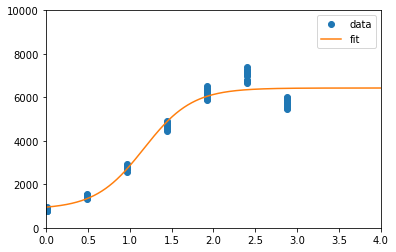

In [57]:
x = np.linspace(0, 4, 10000)
y = sigmoid(x, *popt)

plt.plot(std['Conc_ng/mL'], std['HTRFratio'], 'o', label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
plt.savefig('###output path###'+experiment_id+"_standard_curve.png")

In [59]:
ec100= sigmoid(popt[2],*popt)
ec50_signal = ec100/2

In [60]:
lod_htrf = lod_mean + (10*lod_sd)
lod_conc = 10**(sigmoid_y(lod_htrf, *popt))

<ipython-input-58-580639443a42>:2: RuntimeWarning: invalid value encountered in log
  x = ec50 + (np.log((top /  (y - bottom))-1))/(np.negative(hillslope))


In [64]:
unknowns = samples['HTRFratio']
li=[]
for t in unknowns: 
    if t>popt[0]:
        x = 'Max'                      ##criteria to list as max (will be utilized later in script)
    elif t< (lod_mean + (10*lod_sd)):  ##criteria to list as min if below LoD
        x = 'Min'
    else:
        x = sigmoid_y(t,*popt)
        x = 10** x
    li.append(x)
samples['Interpolated'] = li
samples['Interpolated'] = samples['Interpolated'].fillna('Min')

#update concentration by accomodating for dilution factor
samples['Calc_conc_ng/mL'] = samples['Interpolated'].where((samples['Interpolated'] == 'Max') | (samples['Interpolated'] == 'Min') , (samples['DF']*(samples['Interpolated'])))

<ipython-input-58-580639443a42>:2: RuntimeWarning: invalid value encountered in log
  x = ec50 + (np.log((top /  (y - bottom))-1))/(np.negative(hillslope))


In [ ]:
#assign sample IDs based on information
MCPs = {'q1': 1, 'q2': 7 ,'q3':15,'q4':23}
samples2 = samples.replace({"Quad":MCPs})
samples3 =  samples2[['WellRC_96w','Quad','DF','Calc_conc_ng/mL','HTRFratio']]
samples3.columns = ['WELL_RC_96w','PLATE','DF','CONC_ng/mL','HTRF_RATIO']
samples3['COLUMN']= samples3.WELL_RC_96w.str[-2:]
samples3['COLUMN'] = samples3['COLUMN'].str.lstrip('0')
samples3['ROW']= samples3.WELL_RC_96w.str[:1]
samples3['CLONE'] = samples3['PLATE'].astype(str) + samples3['ROW'].astype(str) + samples3['COLUMN'].astype(str)
samples4 = samples3.reindex()
samples5 = samples4.set_index(['WELL_RC_96w','PLATE','COLUMN','ROW','CLONE'])
reshaped_df = samples5.pivot(columns=['DF'])
reshaped_df['FUSION ID'] = fusion_id
reshaped_df = reshaped_df.reset_index()
reshaped_df.columns = reshaped_df.columns.droplevel()
reshaped_df.columns = ['SAMPLE','PLATE','COLUMN','ROW','CLONE','DF1_ng_per_mL','DF8_ng_per_mL','DF64_ng_per_mL','DF512_ng_per_mL','DF1_HTRFratio','DF8_HTRFratio','DF64_HTRFratio','DF512_HTRFratio','FUSION_ID']

In [ ]:
#max selection of concentration to use
reshaped_df['MAX_HTRF']= reshaped_df[['DF1_HTRFratio','DF8_HTRFratio','DF64_HTRFratio','DF512_HTRFratio']].max(axis=1)

#distance from EC50 is calcualted
reshaped_df['DF1_Distance']= (reshaped_df['DF1_HTRFratio']-ec50_signal).abs()
reshaped_df['DF2_Distance']= (reshaped_df['DF2_HTRFratio']-ec50_signal).abs()
reshaped_df['DF3_Distance']= (reshaped_df['DF3_HTRFratio']-ec50_signal).abs()
reshaped_df['DF4_Distance']= (reshaped_df['DF4_HTRFratio']-ec50_signal).abs()
df= reshaped_df.copy()

#selects interpolated concentration based on distance to EC50
df['Interpolated_conc']= np.where(
    df.DF1_HTRFratio==df.MAX_HTRF,np.where(df.DF1_Distance<df.DF2_Distance,df.DF1_ng_per_mL,df.DF2_ng_per_mL),
    np.where(df.DF2_HTRFratio==df.MAX_HTRF,np.where(df.DF2_Distance<df.DF3_Distance,df.DF2_ng_per_mL,
    df.DF3_ng_per_mL),np.where(df.DF3_HTRFratio==df.MAX_HTRF,np.where
    (df.DF3_Distance<df.DF4_Distance,df.DF3_ng_per_mL,df.DF4_ng_per_mL),"Min")))

#calculate max concentration calculated
df['DF1_ng_per_mL_int'] = pd.to_numeric(df['DF1_ng_per_mL'], errors='coerce').fillna('0').astype(float)
df['DF2_ng_per_mL_int'] = pd.to_numeric(df['DF2_ng_per_mL'], errors='coerce').fillna('0').astype(float)
df['DF3_ng_per_mL_int'] = pd.to_numeric(df['DF3_ng_per_mL'], errors='coerce').fillna('0').astype(float)
df['DF4_ng_per_mL_int'] = pd.to_numeric(df['DF4_ng_per_mL'], errors='coerce').fillna('0').astype(float)
columns = df[['DF1_ng_per_mL_int','DF2_ng_per_mL_int','DF3_ng_per_mL_int','DF4_ng_per_mL_int']]
df['Max_Conc']= columns.max(axis=1)

#if interpolated concentration is max, take max; other wise take iterpolated
df['Interpolated_conc']= np.where(df.Interpolated_conc=='Max',df.Max_Conc,df.Interpolated_conc)

#include all values used to make selection for user to make assessments
final=df[['CLONE','FUSION_ID','Interpolated_conc','DF1_ng_per_mL','DF8_ng_per_mL', 'DF64_ng_per_mL', 'DF512_ng_per_mL','Max_Conc' ,'DF1_HTRFratio','DF8_HTRFratio', 'DF64_HTRFratio', 'DF512_HTRFratio','MAX_HTRF']]

#populate control information
final['EC50_control'] = ec50_signal
final['LOD_blank'] = lod_conc
final.to_excel('###output path###'+ experiment_id+'_output.xls')